In [1042]:
##Imports

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math
from collections import Counter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#Feature Selection and Parameter Tuning
import sklearn.cross_validation as cv
import sklearn.feature_selection as fs
import sklearn.grid_search as gs

In [1043]:
# Transform csv files to corresponding pandas DataFrames
train_df = pd.read_csv('data/train.csv')
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [1044]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1045]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [1046]:
Y_train = train_df['Survived']

#Combining train and test rows to help reduce repeated work in Data Analysis and Feature Engineering
combined_df = train_df.drop('Survived',axis=1).append(test_df)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [1047]:
## Incomplete Columns in Training and Test Data
print("Incomplete Data Columns: ")
print(np.sum(combined_df.loc[:,combined_df.isnull().any(axis=0)==True].isnull()))

Incomplete Data Columns: 
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


In [1048]:
#Description of Numerical Variables
combined_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [1049]:
#Description of Categorical Variables
combined_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


## Finding Deck from Cabin data

Cabin and Ticket features are not unique to passengers. My hypothesis is that by finding out passengers with same ticket or cabin, we can find out the other feature. My idea is to infer the Cabin number (Deck = First Letter) from the common Ticket number if any and from the fare/Pclass.

Steps:

1. Figure out Ticket-Cabin mappings whichever present - Just first letter is also okay
2. Figure out Fare + Pclass -> Cabin mappings -> Just first letter is also okay
3. Need to also figure out is Fare per person or per family 

In [1011]:
# Creating a Cabin Deck Column
for df in [train_df, test_df]:
    df["Deck"] = "Unknown"
    df.loc[pd.notnull(df["Cabin"]), "Deck"] = df["Cabin"].str[0]

In [1012]:
train_df.Deck.value_counts()

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Deck, dtype: int64

We observe majority of the Deck information is Unknown!

### Filling Deck Missing Data

Few Cabins with NaN actually share the same Ticket. We can use this to fill up Deck values. It might so happen that all the passengers with same ticket might have NaN cabin. In that case, we can either:

a) randomly select from the cabin decks of same pclass and Embarked

b) retain Unknown

c) Obtaining Family Trees would be perfect (as described here: https://www.kaggle.com/c/titanic/prospector#208) but not sure if that detail is currently required. Will go back to this later.

Currently, I am retaining Unknown and will explore other options in the future.

In [1013]:
# Creating a Ticket-Deck Dictionary
ticket_deck_map = {}
for index, row in train_df.iterrows():
    if row['Deck'] != 'Unknown':
        ticket_deck_map[row['Ticket']] = row['Deck']

for index, row in test_df.iterrows():
    if row['Deck'] != 'Unknown':
        ticket_deck_map[row['Ticket']] = row['Deck']

In [1014]:
#Filling missing Cabin info
for index, row in train_df.iterrows():
    if row['Deck'] == 'Unknown':
        if row['Ticket'] in ticket_deck_map.keys():
            train_df.loc[index,'Deck'] = ticket_deck_map[row['Ticket']]
            
for index, row in test_df.iterrows():
    if row['Deck'] == 'Unknown':
        if row['Ticket'] in ticket_deck_map.keys():
            test_df.loc[index,'Deck'] = ticket_deck_map[row['Ticket']]

In [1015]:
train_df.Deck.value_counts()

Unknown    676
C           67
B           48
E           33
D           33
A           15
F           14
G            4
T            1
Name: Deck, dtype: int64

Unfortunately, Unknown is still large in number with only 11 missing values filled. Let's explore the relationship between Deck and Survival rate.

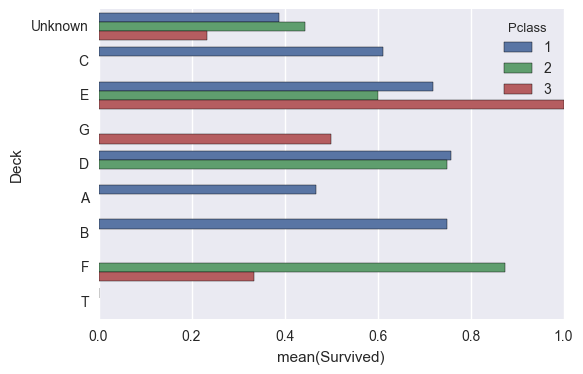

In [1016]:
sns.barplot(hue='Pclass', x="Survived", y="Deck", data = train_df, ci=True)

#### Observations  

1. Independent of the Pclass, the passengers with "Unknown" Deck have the Lowest Survival rate.

2. All passengers in Cabin E Pclass = 3 survived!

3. Cabin T is not present in training data set

4. Cabin A,B,C had only passengers from Pclass=1 in training data set.

5. Deck should definitely be a feature for the prediction.

## Ticket Data

In [1024]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip() , ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

In [1025]:
train_df['Ticket'] = train_df['Ticket'].map(cleanTicket)

In [1026]:
np.unique(train_df.Ticket)

array(['A4', 'A5', 'AS', 'C', 'CA', 'CASOTON', 'FC', 'FCC', 'Fa', 'LINE',
       'PC', 'PP', 'PPP', 'SC', 'SCA4', 'SCAH', 'SCOW', 'SCPARIS',
       'SCParis', 'SOC', 'SOP', 'SOPP', 'SOTONO2', 'SOTONOQ', 'SP',
       'STONO', 'STONO2', 'SWPP', 'WC', 'WEP', 'XXX'], dtype=object)

## Fare Per Person 

There are passengers with same ticket numbers and their fare listed is actually the sum total and not individual. When we divide the fare of such passengers by the shared number, the fare of Pclass = 1 gets closer to the Pclass=2 and 3 passengers. It will be interesting to analyze the spread of the fares per person.

In [1030]:
train_df['FarePerPerson'] = train_df['Fare']
test_df['FarePerPerson'] = train_df['Fare']

# Indicator for a Ticket held by Multi-Passengers 0 = No, 1 - Yes
train_df['MultiTickets'] = pd.DataFrame(np.zeros((train_df.shape[0],1)))
test_df['MultiTickets'] = pd.DataFrame(np.zeros((test_df.shape[0],1)))

for index, row in train_df.iterrows():
        count1 = len(Counter(train_df.loc[train_df.Ticket==row['Ticket'],'Ticket']))
        count2 = len(Counter(test_df.loc[test_df.Ticket==row['Ticket'],'Ticket']))
        if count1 + count2 > 1:
            train_df.loc[index,'MultiTickets'] = 1
            train_df.loc[index,'FarePerPerson'] = float(row['Fare']/(count1+count2))

for index, row in test_df.iterrows():
        count1 = len(Counter(train_df.loc[train_df.Ticket==row['Ticket'],'Ticket']))
        count2 = len(Counter(test_df.loc[test_df.Ticket==row['Ticket'],'Ticket']))
        if count1 + count2 > 1:
            test_df.loc[index,'MultiTickets'] = 1
            test_df.loc[index,'FarePerPerson'] = float(row['Fare']/(count1+count2))  

# Dropping Columns not required again
train_df.drop(['Cabin','Ticket','Fare'],axis=1,inplace=True)
test_df.drop(['Cabin','Ticket','Fare'],axis=1,inplace=True)

KeyError: 'Fare'

In [994]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Deck,FarePerPerson,MultiTickets
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S,Unknown,7.25000,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C,C,35.64165,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S,Unknown,7.92500,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S,C,53.10000,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S,Unknown,8.05000,0.0


## Family 

In [1028]:
# Adding Family as a new Feature column in train_df. Family = Parch + SibSp
train_df['Family'] = train_df['Parch'] + train_df['SibSp'] + 1
test_df['Family'] = test_df['Parch'] + train_df['SibSp'] + 1

train_df.drop(['Parch','SibSp'],axis=1,inplace=True)
test_df.drop(['Parch','SibSp'],axis=1,inplace=True)

## Titles

Several names have titles that can provide another degree of freedom in our Analysis. Titles indicate the whether the passenger was a Civilian or Staff member in Titanic. Also, they indicate an adult vs child, honorary member vs regular citizen etc.

In [1029]:
# Adding Title feature
train_df['Title'] = train_df.Name.map(lambda name:name.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df.Name.map(lambda name:name.split(',')[1].split('.')[0].strip())

# a map of more aggregated titles
Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
train_df['Title'] = train_df.Title.map(Title_Dictionary)
test_df['Title'] = test_df.Title.map(Title_Dictionary)
    
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [997]:
np.unique(train_df.Title)

array(['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty'], dtype=object)

## Exploratory Data Analysis

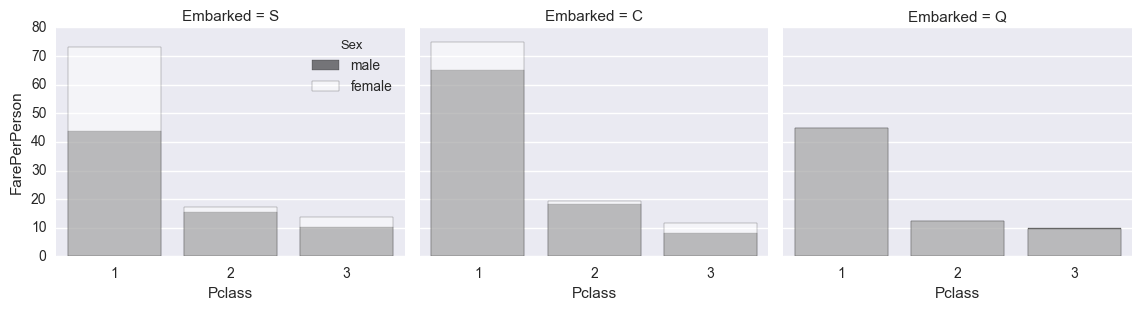

In [959]:
grid = sns.FacetGrid(train_df, col='Embarked', hue='Sex',palette={'male': 'k', 'female': 'w'},size=3.2, aspect=1.2, legend_out=False)
grid.map(sns.barplot, 'Pclass', 'FarePerPerson', alpha=0.5, ci=False)
grid.add_legend()

#### Observations

1. Fare per person is almost always higher for female passengers independent of Port and Pclass.

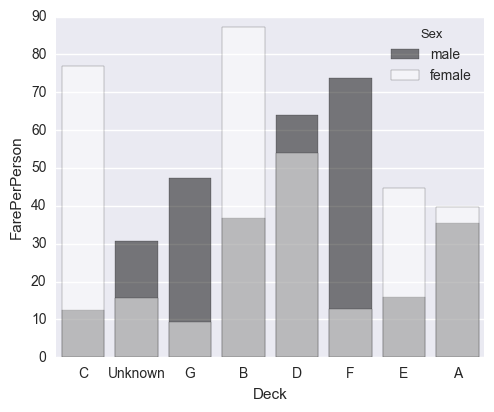

In [960]:
grid = sns.FacetGrid(train_df, hue='Sex',palette={'male': 'k', 'female': 'w'},size=4.2, aspect=1.2, legend_out=False)
grid.map(sns.barplot, 'Deck', 'FarePerPerson', alpha=0.5, ci=False)
grid.add_legend()

#### Observations

1. Depending on the Deck, the fare difference is significantly higher either for Female or Male passengers
   
   a) Female > Male in Decks C, B, E and only slightly higher in A
   
   b) Male > Female in Decks G, F, Unknown and slightly higher in D
 
2. This could be because of the age distribution of passengers in each Deck and accordingly the FarePerPerson changing with the age.
    

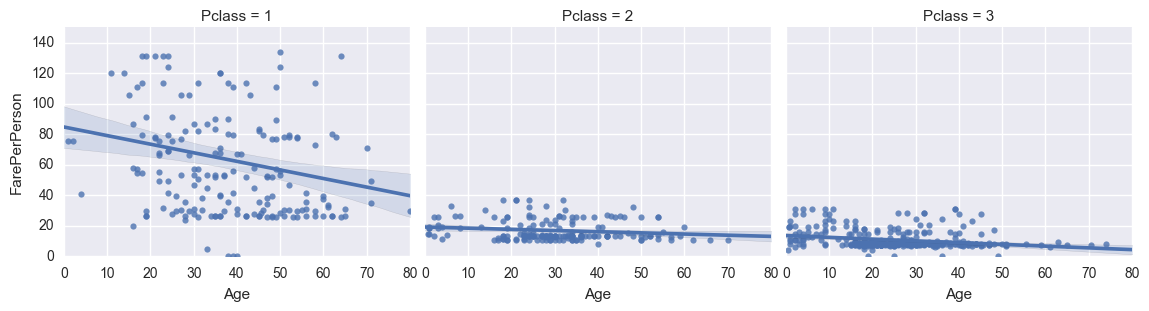

In [961]:
grid = sns.FacetGrid(train_df, col='Pclass', size=3.2, aspect=1.2, legend_out=False)
grid.map(sns.regplot, 'Age', 'FarePerPerson')
grid.set(ylim=((0,150)))
grid.set(xlim=((0,80)))
grid.add_legend()

#ax1 = sns.regplot(train_df['Age'],train_df['FarePerPerson'])
#ax1 = sns.regplot(train_df.loc[train_df.Pclass==3,'Age'],train_df.loc[train_df.Pclass==3,'FarePerPerson'])
#ax1.set_ylim([0,50])
#ax1.set_xlim([40,90])

#### Observations:

1. Fare Per Person is among the lowest for ages > 60 for each of the Pclass.

2. Fare per person for ages < 10 is not in the lowest for any of the Pclasses. This is because most children are accompanied by parents or siblings. So, the Fare Per Person obtained on averaging the fare is not the true Fare per child. 

3. As shown below, there is a single Child with Parch=0 on the ship. It is difficult to estimate if there is a fixed Fare for children considering the Fare has been observed to vary per Pclass, age, gender and Deck.

In [962]:
train_df.loc[(train_df.Age < 10) & (train_df.Family==0),:]

,PassengerId,Survived,Pclass,Sex,Age,Embarked,Deck,FarePerPerson,MultiTickets,Family,Title
777,778,1,3,female,5.0,S,Unknown,12.475,0.0,0,Miss.


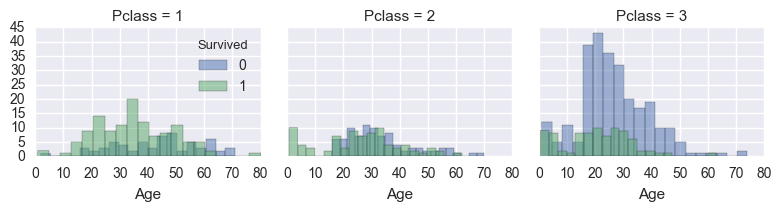

In [963]:
#fig = plt.figure(figsize=(15,15))
#sns.linearmodels.corrplot(train_df)
#plt.title("Correlation Matrix Visualization",fontsize=18)

grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived', size=2.2, aspect=1.2, legend_out=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

#### Observations:

1) Infants in Pclass = 2 have all survived.

2) Pclass = 3 has most passengers but most did not survive.

3) Pclass = 1 has highest survival rate

4) Both Age and Pclass should be included in Model training.


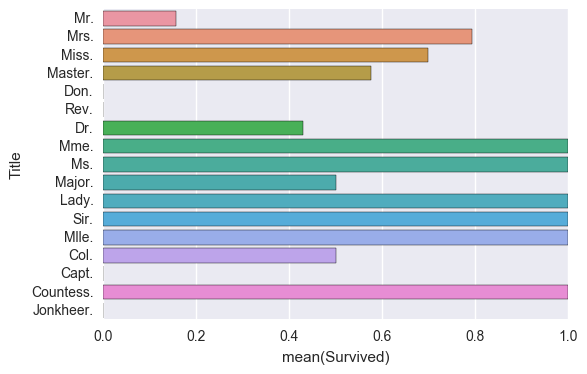

In [964]:
sns.barplot(x="Survived", y="Title", data = train_df, ci=False)

### Observations:

1) Female Titles including Mme., Ms., Mlle. etc. had 100% survival.

2) On the other hand, titles including Mr., Col. Capt. had 0-18% survival

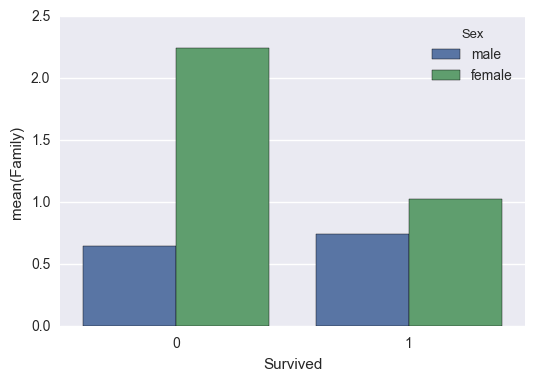

In [965]:
sns.barplot(x="Survived", y="Family", hue="Sex",data = train_df, ci=False)

#### Observations

Those who survived, interestingly had a lower average for Family. This might be because the non-survivors died while trying to save their relatives.

## Converting Categorical features to numerical features

In [966]:
#Sex to Gender
train_df['Gender'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test_df['Gender'] = test_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df = train_df.drop(['Sex'], axis=1)
test_df = test_df.drop(['Sex'], axis=1)

In [967]:
train_df.head()

,PassengerId,Survived,Pclass,Age,Embarked,Deck,FarePerPerson,MultiTickets,Family,Title,Gender
0,1,0,3,22.0,S,Unknown,7.25000,0.0,1,Mr.,0
1,2,1,1,38.0,C,C,35.64165,1.0,1,Mrs.,1
2,3,1,3,26.0,S,Unknown,7.92500,0.0,0,Miss.,1
3,4,1,1,35.0,S,C,53.10000,0.0,1,Mrs.,1
4,5,0,3,35.0,S,Unknown,8.05000,0.0,0,Mr.,0


## Completing a numerical continuous feature - Age

In [968]:
# Using correlated features: Pclass, Gender

age_estimate = np.zeros([2,3]) # 2- Gender, 3 - Pclass

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = train_df[(train_df['Gender'] == i) & \
                              (train_df['Pclass'] == j+1)]['Age'].dropna()
        
        age_est = guess_df.median()

        # Convert random age float to nearest .5 age
        age_estimate[i,j] = int(age_est/0.5 + 0.5 ) * 0.5
        
age_estimate

array([[ 40. ,  30. ,  25. ],
       [ 35. ,  28. ,  21.5]])

In [969]:
train_df['AgeFill'] = train_df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        train_df.loc[ (train_df.Age.isnull()) & (train_df.Gender == i) & (train_df.Pclass == j+1),\
                'AgeFill'] = age_estimate[i,j]

#train_df[train_df['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head(10)

#Also for Testing Data Set
age_estimate = np.zeros([2,3])

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = test_df[(test_df['Gender'] == i) & \
                              (test_df['Pclass'] == j+1)]['Age'].dropna()

        # Correlation of AgeFill is -0.014850
        # age_mean = guess_df.mean()
        # age_std = guess_df.std()
        # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        # Correlation of AgeFill is -0.011304
        age_est = guess_df.median()

        age_estimate[i,j] = int( age_est/0.5 + 0.5 ) * 0.5

test_df['AgeFill'] = test_df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        test_df.loc[ (test_df.Age.isnull()) & (test_df.Gender == i) & (test_df.Pclass == j+1),\
                'AgeFill'] = age_estimate[i,j]
        
train_df = train_df.drop(['Age'], axis=1)
test_df = test_df.drop(['Age'], axis=1)
train_df.head()        

,PassengerId,Survived,Pclass,Embarked,Deck,FarePerPerson,MultiTickets,Family,Title,Gender,AgeFill
0,1,0,3,S,Unknown,7.25000,0.0,1,Mr.,0,22.0
1,2,1,1,C,C,35.64165,1.0,1,Mrs.,1,38.0
2,3,1,3,S,Unknown,7.92500,0.0,0,Miss.,1,26.0
3,4,1,1,S,C,53.10000,0.0,1,Mrs.,1,35.0
4,5,0,3,S,Unknown,8.05000,0.0,0,Mr.,0,35.0


## Completing a categorical feature - Embarked

In [970]:
# With only 2 values missing in Training Data set and 0 in Test Datra Set
# We simply place the most popular Embarkment port for missing data

popular_embarkment = train_df.Embarked.dropna().mode()[0]
popular_embarkment

'S'

In [971]:
train_df['EmbarkedFill'] = train_df['Embarked']
train_df.loc[train_df['Embarked'].isnull(),'EmbarkedFill'] = popular_embarkment

test_df['EmbarkedFill'] = test_df['Embarked']
train_df = train_df.drop(['Embarked'], axis=1)
test_df = test_df.drop(['Embarked'], axis=1)
train_df.head()

,PassengerId,Survived,Pclass,Deck,FarePerPerson,MultiTickets,Family,Title,Gender,AgeFill,EmbarkedFill
0,1,0,3,Unknown,7.25000,0.0,1,Mr.,0,22.0,S
1,2,1,1,C,35.64165,1.0,1,Mrs.,1,38.0,C
2,3,1,3,Unknown,7.92500,0.0,0,Miss.,1,26.0,S
3,4,1,1,C,53.10000,0.0,1,Mrs.,1,35.0,S
4,5,0,3,Unknown,8.05000,0.0,0,Mr.,0,35.0,S


## Converting categorical variables to numerical variables

In [972]:
# Convert Embarked, Deck and Titles features using Pandas get_dummies()

#Decks
Deck_train = pd.get_dummies(train_df['Deck'],prefix='Deck_')
train_df = pd.concat([train_df,Deck_train],axis=1)
train_df.drop('Deck',axis=1,inplace=True)

Deck_test = pd.get_dummies(test_df['Deck'],prefix='Deck_')
test_df = pd.concat([test_df,Deck_test],axis=1)
test_df.drop('Deck',axis=1,inplace=True)

#Embarked
Embarked_train = pd.get_dummies(train_df['EmbarkedFill'],prefix='Port_')
train_df = pd.concat([train_df,Embarked_train],axis=1)
train_df.drop('EmbarkedFill',axis=1,inplace=True)

Embarked_test = pd.get_dummies(test_df['EmbarkedFill'])
test_df = pd.concat([test_df,Embarked_test],axis=1)
test_df.drop('EmbarkedFill',axis=1,inplace=True)

#Title
titles_train = pd.get_dummies(train_df['Title'])
train_df = pd.concat([train_df,titles_train],axis=1)
#train_df.drop('Title',axis=1,inplace=True)

titles_test = pd.get_dummies(test_df['Title'])
test_df = pd.concat([test_df,titles_test],axis=1)

# Disparity in Unique Titles in train_df and test_df
# Some of the titles present in train_df might not be present in test_df
# We need to add zero columns for such titles in the test_df
#Remove Extra Title column from test_df that are absent from train_df

titles_train = list(np.unique(train_df['Title']))
titles_test = list(np.unique(test_df['Title']))

titles_extra_in_train_bool = np.array([x not in titles_test for x in titles_train])
titles_extra_in_train = list(np.array(titles_train)[titles_extra_in_train_bool])
#titles_extra_df = pd.DataFrame(np.zeros(()))
print("Extra titles in train_df:")
print(titles_extra_in_train)

titles_extra_in_test_bool = np.array([x not in titles_train for x in titles_test])
titles_extra_in_test = list(np.array(titles_test)[titles_extra_in_test_bool])
print("Extra titles in test_df:")
print(titles_extra_in_test)

# Adding extra Title columns to test_df
Ncols = len(titles_extra_in_train)
titles_extra_to_test_df = pd.DataFrame(np.zeros([test_df.shape[0],len(titles_extra_in_train)]),columns = titles_extra_in_train)
test_df = pd.concat([test_df,titles_extra_to_test_df],axis=1)
test_df.head()

#Dropping extra columns
test_df.drop(titles_extra_in_test,axis=1,inplace=True)

Extra titles in train_df:
['Capt.', 'Countess.', 'Don.', 'Jonkheer.', 'Lady.', 'Major.', 'Mlle.', 'Mme.', 'Sir.']
Extra titles in test_df:
['Dona.']


In [973]:
## Use this for without dummies

#train_df.columns.values
#Ports = list(enumerate(np.unique(pd.concat([train_df['EmbarkedFill'],test_df['EmbarkedFill']],axis=0))))
#Ports_dict = { name : i for i, name in Ports }      

#train_df['Port'] = train_df.EmbarkedFill.map( lambda x: Ports_dict[x]).astype(int)
#test_df['Port'] = test_df.EmbarkedFill.map( lambda x: Ports_dict[x]).astype(int)
#train_df[['EmbarkedFill', 'Port']].head(10)

In [974]:
train_df = train_df.drop(['Title'], axis=1)
test_df = test_df.drop(['Title'], axis=1)
train_df.head()

,PassengerId,Survived,Pclass,FarePerPerson,MultiTickets,Family,Gender,AgeFill,Deck__A,Deck__B,...,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.
0,1,0,3,7.25000,0.0,1,0,22.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,1,35.64165,1.0,1,1,38.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,1,3,7.92500,0.0,0,1,26.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,53.10000,0.0,1,1,35.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,0,3,8.05000,0.0,0,0,35.0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [975]:
# Completing one missing value of Fare feature in Test data set
test_df['FarePerPerson'].fillna(test_df['FarePerPerson'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,FarePerPerson,MultiTickets,Family,Gender,AgeFill,Deck__A,Deck__B,Deck__C,...,Rev.,Capt.,Countess.,Don.,Jonkheer.,Lady.,Major.,Mlle.,Mme.,Sir.
0,892,3,7.25000,0.0,1.0,0,34.5,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,893,3,71.28330,0.0,1.0,1,47.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,894,2,7.92500,0.0,0.0,0,62.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,895,3,53.10000,0.0,1.0,0,27.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,896,3,6.14375,1.0,1.0,1,22.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prediction Modeling

In [976]:
X_train = train_df.drop(['Survived','Deck__T'], axis=1).copy()
Y_train = train_df["Survived"]
X_test  = test_df.copy()

#X_train = X_train[['Pclass','Gender','AgeFill','DeckBand','TitleBand']]
#X_test = X_test[['Pclass','Gender','AgeFill','DeckBand','TitleBand']]


X_train.shape, Y_train.shape, X_test.shape

((891, 35), (891,), (418, 35))

Also compute Normalized training set for Classifiers such as SVM.

In [977]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X_train)
X_train_norm = pd.DataFrame(np_scaled,columns = X_train.columns)

np_scaled = min_max_scaler.fit_transform(X_test)
X_test_norm = pd.DataFrame(np_scaled,columns = X_test.columns)

## Random Forest

## GridSearch

In [871]:
randomForest = RandomForestClassifier()

grid_para_forest = [{"n_estimators": [10, 20, 30, 40,50], "criterion": ["gini", "entropy"], \
                    "min_samples_leaf": np.arange(1, 15), "min_samples_split": np.array([int(x) for x in np.linspace(2, 15,30)])}]
grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy',cv=3)
grid_search_forest.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'criterion': ['gini', 'entropy'], 'min_samples_split': array([ 2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15]), 'n_estimators': [10, 20, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

### Random Forest Best Params Analysis

In [873]:
grid_search_forest.best_score_

0.8428731762065096

In [877]:
grid_search_forest.score(X_train,Y_train)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.88215488215488214

In [874]:
grid_search_forest.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 30}

In [875]:
randomForest_best = RandomForestClassifier(criterion='entropy',min_samples_leaf=3,min_samples_split=5,n_estimators=30)
randomForest_best.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [921]:
feature_importance = zip(X_train.columns, randomForest_best.feature_importances_)
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_sort = sorted(feature_importance, key=lambda tup: tup[1],reverse=True)
feature_sort
top_feat = [i for (i, j) in feature_sort[0:10]]

### Observations

Interesting features in the top 10 include Deck_Unknown, Mr., Mrs., Miss, Master

Next step:

1) Perform a Grid Search with only the top 10 features

2) Perform a Recursive Feature Extraction over all features using the Best Estimator obtained above

### Random Forest over Top 10 features

In [934]:
X_train_filt = X_train[top_feat]
X_test_filt = X_test[top_feat]
X_train_filt.head()

,Gender,Mr.,FarePerPerson,AgeFill,Pclass,Family,Mrs.,Deck__Unknown,Miss.,Master.
0,0,1,7.25000,22.0,3,1,0,1,0,0
1,1,0,35.64165,38.0,1,1,1,0,0,0
2,1,0,7.92500,26.0,3,0,0,1,1,0
3,1,0,53.10000,35.0,1,1,1,0,0,0
4,0,1,8.05000,35.0,3,0,0,1,0,0


In [923]:
randomForest_filt = RandomForestClassifier()

grid_para_forest = [{"n_estimators": [10, 20, 30, 40,50], "criterion": ["gini", "entropy"], \
                    "min_samples_leaf": np.arange(1, 20), "min_samples_split": np.array([int(x) for x in np.linspace(2, 15,30)])}]
grid_search_forest = gs.GridSearchCV(randomForest_filt, grid_para_forest, scoring='accuracy',cv=3)
grid_search_forest.fit(X_train_filt, Y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]), 'criterion': ['gini', 'entropy'], 'min_samples_split': array([ 2,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15]), 'n_estimators': [10, 20, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

## Recursive Feature Extraction

In [924]:
grid_search_forest.best_score_

0.8451178451178452

In [926]:
grid_search_forest.score(X_train_filt,Y_train)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.877665544332211

In [910]:
rfe = fs.RFE(randomForest_best,20)
rfe.fit(X_train,Y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
  n_features_to_select=20, step=1, verbose=0)

In [911]:
rfe.score(X_train,Y_train)

0.88327721661054992

In [935]:
Y_pred = grid_search_forest.predict(X_test_filt)

In [937]:
X_test_filt.shape

(418, 10)

## KAGGLE Submission File

In [938]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })

submission.to_csv('submission_rf_filt.csv', index=False)